# Handwritten Digits Classifier with Scikit-Learn

### Author: Salvatore Porcheddu
### Date: 2021-09-14

This project is about building a machine learning model that can predict digits that were handwritten and then digitally rendered. The images of the handwritten digits will come from the digits dataset in scikit-learn, which itself is a copy of the "Optical Recognition of Handwritten Digits Data Set" from the UCI, that can be found [here](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

The dataset contains 1797 observations, where each observation represents a handwritten digit image of 8x8 pixels, so we have 64 columns plus the label column.

### Step 1: Importing The Data And Visualizing Some Of The Digits

In [1]:
# importing relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# disabling useless warnings

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing the data

data = load_digits(as_frame=True)

features = data["data"]
labels = data["target"]

print(features.head(), "\n")
print(labels.head())

   pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0        0.0        0.0        5.0       13.0        9.0        1.0   
1        0.0        0.0        0.0       12.0       13.0        5.0   
2        0.0        0.0        0.0        4.0       15.0       12.0   
3        0.0        0.0        7.0       15.0       13.0        1.0   
4        0.0        0.0        0.0        1.0       11.0        0.0   

   pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_6  pixel_6_7  \
0        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1        0.0        0.0        0.0        0.0  ...        0.0        0.0   
2        0.0        0.0        0.0        0.0  ...        5.0        0.0   
3        0.0        0.0        0.0        8.0  ...        9.0        0.0   
4        0.0        0.0        0.0        0.0  ...        0.0        0.0   

   pixel_7_0  pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  \
0        0.0        0.0        6.0       13.0

In [3]:
# Selecting some observations to visualize and reshaping them to their original shape (8x8)

indices_first_row = [0, 99, 199, 299]  # we will create a figure with two rows of four subplots
indices_second_row = [999, 1099, 1199, 1299]
images_first = []
images_second = []

for index_1, index_2 in zip(indices_first_row, indices_second_row):
    im_1 = features.iloc[index_1].copy().values
    im_1 = np.reshape(im_1, (8,8))
    images_first.append(im_1)
    
    im_2 = features.iloc[index_2].copy().values
    im_2 = np.reshape(im_2, (8,8))
    images_second.append(im_2)
    
# An image matrix looks like this
images_first[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

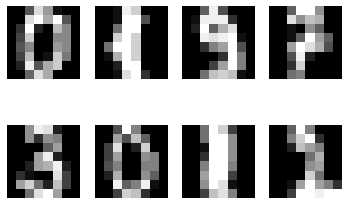

In [4]:
# Creating a figure and plotting the images

fig, ax = plt.subplots(2, 4)

for i, image_i in enumerate(images_first):
    for j, image_j in enumerate(images_second):
        ax[0, i].imshow(image_i, cmap="gray")
        ax[0, i].set_axis_off()
        
        ax[1, j].imshow(image_j, cmap="gray")
        ax[1, j].set_axis_off()
        
plt.show()

### Step 2: Trying The K-Nearest Neighbors Classifier

In [5]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=27)

# Defining a useful function to perform 4-fold cross-validation with different k values and then evaluate how the model performs on the test set

def cross_validate_kneigh(k):
    cv_accuracies = []
    
    cv = KFold(4)
    knn = KNeighborsClassifier(k)
    
    for train_index, test_index in cv.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        
        knn.fit(X_train_cv, y_train_cv)
        preds = knn.predict(X_test_cv)
        acc = accuracy_score(y_test_cv, preds)
        
        cv_accuracies.append(acc)
        
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)
    test_acc = accuracy_score(y_test, preds)
    
    return np.mean(cv_accuracies), test_acc
    

In [6]:
# Experimenting with different k values

ks = range(2, 11)

cv_scores = []
test_scores = []

for k in ks:
    cv_score, test_score = cross_validate_kneigh(k)
    cv_scores.append(cv_score)
    test_scores.append(test_score)

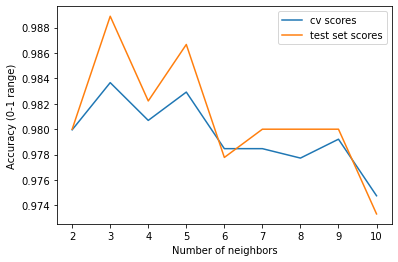

In [7]:
# Plotting the accuracies

plt.plot(ks, cv_scores, label="cv scores")
plt.plot(ks, test_scores, label="test set scores")
plt.legend()
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (0-1 range)")
plt.show()

The model with 3 neighbors got the best accuracy; test set scores are almost always higher than the cross-validated scores, which is a good sign. 
We can see that all the k values tested yield excellent performance (between 97 and 99% of digits are correctly identified).

### Step 3: Neural Network With One Hidden Layer

In [8]:
# Modifying the 'cross_validate_kneigh' function to be used with neural networks with varying number of neurons and hidden layers

def cross_validate_nn(n):
    cv_accuracies = []
    
    cv = KFold(4)
    nn = MLPClassifier(hidden_layer_sizes=n)
    
    for train_index, test_index in cv.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        
        nn.fit(X_train_cv, y_train_cv)
        preds = nn.predict(X_test_cv)
        acc = accuracy_score(y_test_cv, preds)
        
        cv_accuracies.append(acc)
        
    nn.fit(X_train, y_train)
    preds_test = nn.predict(X_test)
    test_acc = accuracy_score(y_test, preds_test)
    
    preds_train = nn.predict(X_train)
    train_acc = accuracy_score(y_train, preds_train)
    
    return np.mean(cv_accuracies), test_acc, train_acc

In [9]:
# Experimenting with different numbers of neurons

neurons = [(8,), (16,), (32,), (64,), (128,), (256,)]

cv_scores = []
test_scores = []
train_scores = []

for n in neurons:
    cv_score, test_score, train_score = cross_validate_nn(k)
    cv_scores.append(cv_score)
    test_scores.append(test_score)
    train_scores.append(train_score)

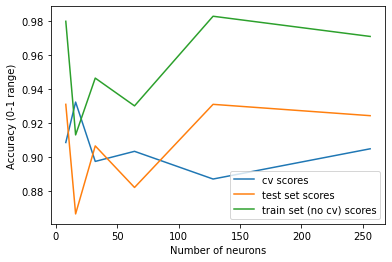

In [10]:
# Plotting the accuracies

plt.plot(neurons, cv_scores, label="cv scores")
plt.plot(neurons, test_scores, label="test set scores")
plt.plot(neurons, train_scores, label="train set (no cv) scores")
plt.legend()
plt.xlabel("Number of neurons")
plt.ylabel("Accuracy (0-1 range)")
plt.show()

With one layer, we achieve the best performance with 8 neurons. No significant overfitting can be observed.

### Step 4: Neural Network With Two Hidden Layers

In [11]:
# Let's use 64 neurons for both neural networks

cv_score, test_score, train_score = cross_validate_nn((64, 64,))

print(f"Average cross-validated accuracy score: {cv_score:.4f}")
print(f"Test set accuracy score: {test_score:.4f}")
print(f"Train set accuracy score: {train_score:.4f}")

Average cross-validated accuracy score: 0.9718
Test set accuracy score: 0.9667
Train set accuracy score: 1.0000


With two layers, we get better accuracy but still a bit less than the KNeighbors model. Still no significant overfitting.

### Step 5: Neural Network With Three Hidden Layers

In [12]:
# Experimenting with different numbers of neurons

neurons = [(10,10,10,), (64,64,64,), (128,128,128,)]

cv_scores = []
test_scores = []
train_scores = []

for n in neurons:
    cv_score, test_score, train_score = cross_validate_nn(k)
    cv_scores.append(cv_score)
    test_scores.append(test_score)
    train_scores.append(train_score)

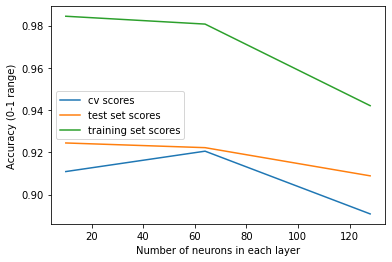

In [14]:
# Plotting the accuracies

plt.plot([10, 64, 128], cv_scores, label="cv scores")
plt.plot([10, 64, 128], test_scores, label="test set scores")
plt.plot([10, 64, 128], train_scores, label="training set scores")
plt.legend(loc="best")
plt.xlabel("Number of neurons in each layer")
plt.ylabel("Accuracy (0-1 range)")
plt.show()

With three layers, performance is slightly worse than before, especially if we increase the number of neurons.